In [1]:
from typing import List
from itertools import combinations
import numpy as np
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
dir = "./data/random/fixed/"
real = dd.read_parquet(dir+"main.parquet", columns=["spec","variant","real.tests", "real.downs", "size", "clocks"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","approx.tests", "approx.downs", "limit.tests", "limit.downs"])
opti = dd.read_parquet(dir+"opti/init_weights.min_front.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [3]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()

### Difference percentage limit vs real max

<AxesSubplot:xlabel='spec'>

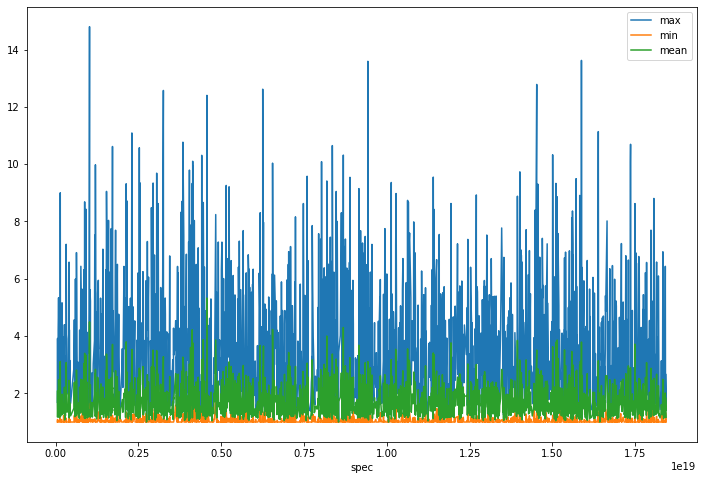

In [4]:
(comparison_squished["limit.tests"]/comparison_squished["real.tests"]).groupby("spec").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Specifications that fails to be approximated correctly

In [5]:
comparison_squished[comparison_squished["approx.tests"] < comparison_squished["real.tests"]]

real.tests  real.downs  size  clocks  \
spec                 variant                                         
57036280707606070    48              178          90     6       9   
                     49              238         102     6       9   
                     50              186          94     6       9   
                     52              274         114     6       9   
                     54              178          90     6       9   
...                                  ...         ...   ...     ...   
18415264097865192794 118             160          50     5       6   
18432962492680829874 0                74          30     4       5   
                     2                74          30     4       5   
                     6                73          29     4       5   
                     12               73          29     4       5   

                              approx.tests  approx.downs  limit.tests  \
spec                 variant                                            
57036280707606070    48                168            84          504   
                     49                223           128          568   
                     50                180            89          536   
                     52                258           138          616   
                     54                168            84          504   
...                                    ...           ...          ...   
18415264097865192794 118               152            54          220   
18432962492680829874 0                  70            28          104   
                     2                  70            28          104   
                     6                  69            27           81   
                     12                 69            27           81   

                              limit.downs  
spec                 variant               
57036280707606070    48               348  
                     49               348  
                     50               364  
                     52               364  
                     54               348  
...                                   ...  
18415264097865192794 118               92  
18432962492680829874 0                 44  
                     2                 44  
                     6                 33  
                     12                33  

[122022 rows x 8 columns]

### Raw limit vs real max percentage

<AxesSubplot:xlabel='spec,variant'>

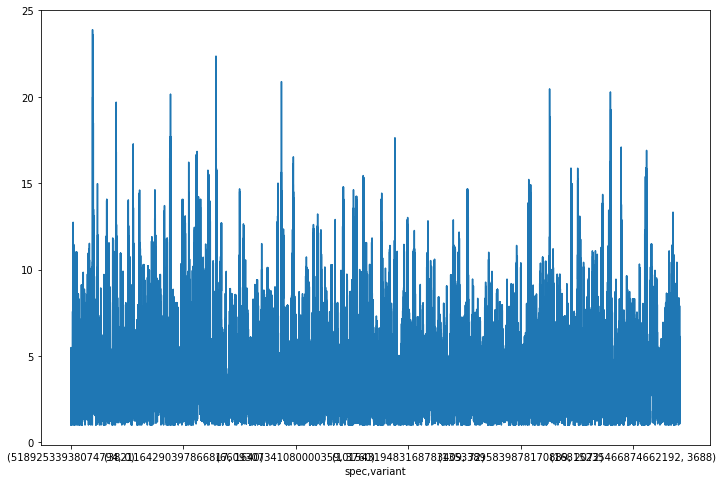

In [6]:
(comparison_squished["limit.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [7]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison_opti = compare.compute()

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


### Specification complexity range evolution (natural order)

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='spec'>

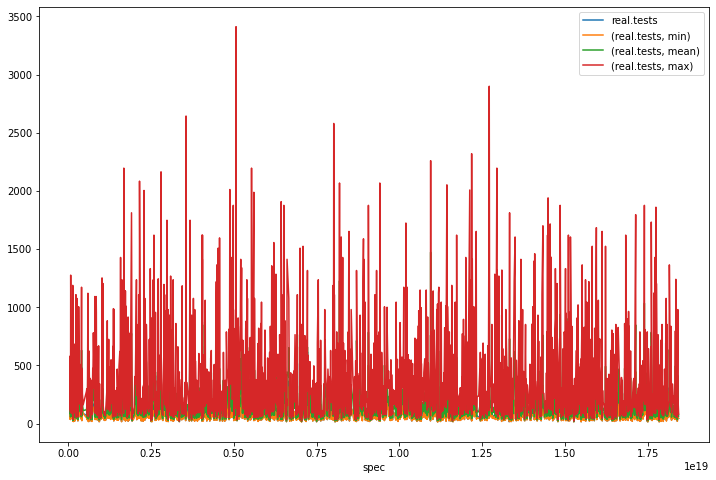

In [8]:
comparison_opti[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

### Specification complexity range evolution (size)

<AxesSubplot:xlabel='size', ylabel='diff'>

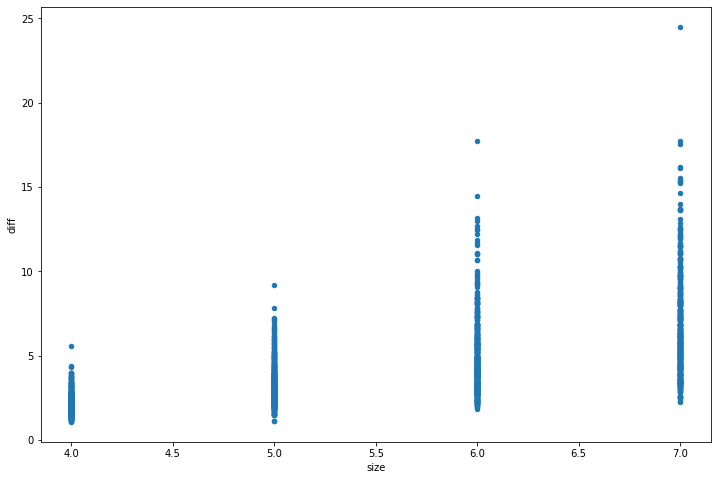

In [9]:
comparison_opti2 = comparison_opti.sort_values(("clocks", "max"))
comparison_opti2["diff"] = comparison_opti2[("real.tests", "max")]/comparison_opti2[("real.tests", "min")]
comparison_opti2["size"] = comparison_opti2[("size","max")]
comparison_opti2["clocks"] = comparison_opti2[("clocks","max")]
comparison_opti2.sort_values("size").plot.scatter(x="size", y="diff",figsize=(12, 8))

<AxesSubplot:xlabel='clocks', ylabel='diff'>

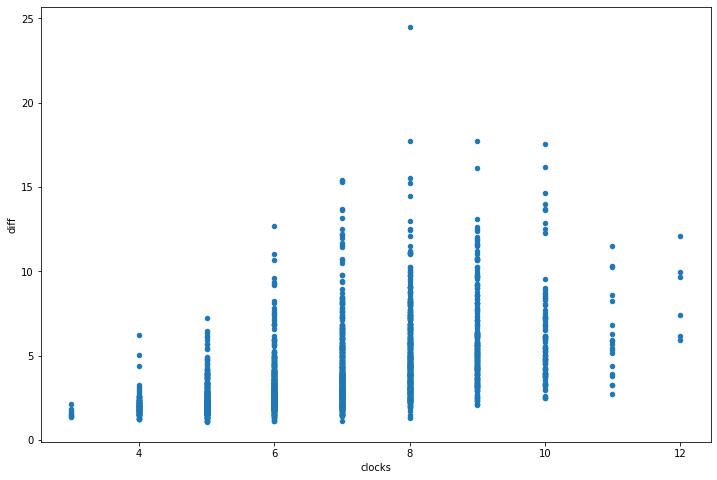

In [10]:
comparison_opti2.sort_values("clocks").plot.scatter(x="clocks", y="diff",figsize=(12, 8))

### All failed to optimize specifications

In [11]:
comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs
spec,,,,,,,,,,,,,,,,
679281214975076496,84,148,113.333333,36,52,43.333333,4,4,4.0,5,5,5.0,0,7,116,44
850935003934676898,201,956,430.388095,87,302,148.161905,7,7,7.0,8,8,8.0,3961,3,482,153
893115874160242334,84,148,113.333333,36,52,43.333333,4,4,4.0,6,6,6.0,0,3,116,44
2462869174627452095,84,148,113.333333,36,52,43.333333,4,4,4.0,6,6,6.0,3,3,116,44
4087092928349477203,29,89,56.200000,9,29,18.900000,5,5,5.0,6,6,6.0,84,0,58,18
7341688890593459552,124,260,180.733333,56,92,70.400000,5,5,5.0,5,5,5.0,36,15,184,70
8139600420793084657,37,51,44.083333,12,17,14.500000,4,4,4.0,4,4,4.0,3,0,48,15
8678028512220747566,148,340,237.600000,68,116,90.400000,5,5,5.0,6,6,6.0,10,15,244,92
11606009959643938094,18,24,19.833333,8,12,9.166667,4,4,4.0,6,6,6.0,2,1,20,10


### Percentage of badly optimized specifications

In [12]:
len(comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]])/len(comparison_opti)

0.005238095238095238

### Scatter plot of permutations' real test values for each specification

<AxesSubplot:xlabel='spec', ylabel='real.tests'>

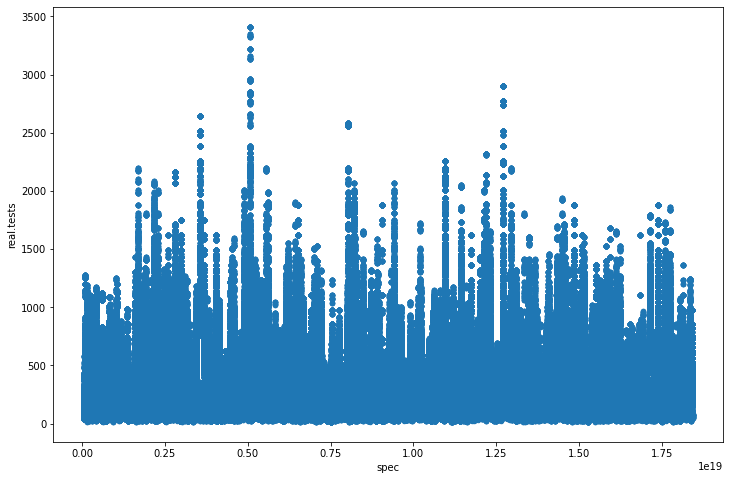

In [13]:
frame = real_max.compute()
frame.reset_index(inplace=True)
frame.plot.scatter(x="spec", y="real.tests", figsize=(12, 8))

### Relative scatter plot

In [14]:
relative_dist = real_max.compute().reset_index(level="variant").join(real_statistics.compute(), on="spec")
relative_dist

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)"
spec,,,,,,,,,,,,,,,,,
51892533938074794,0,63,27,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,1,87,33,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,2,63,27,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,3,87,33,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
51892533938074794,4,87,33,4,4,56,132,92.75,26,48,36.250000,4,4,4.0,4,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432962492680829874,19,62,28,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0
18432962492680829874,20,76,32,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0
18432962492680829874,21,54,25,4,5,44,80,63.75,21,34,27.416667,4,4,4.0,5,5,5.0


In [15]:
def scale_reals(row):
    new_rows = dict()
    test_min = row[("real.tests", "min")]
    test_max = row[("real.tests", "max")]
    if test_max == test_min:
        new_rows["rel_tests"] = 0
    else:
        new_rows["rel_tests"] = (row["real.tests"] - test_min) / (test_max - test_min)
    down_min = row[("real.downs", "min")]
    down_max = row[("real.downs", "max")]
    if down_min == down_max:
        new_rows["rel_downs"] = 0
    else:
        new_rows["rel_downs"] = (row["real.downs"] - down_min) / (down_max - down_min)
    new_rows["size"] = row["size"]
    new_rows["clocks"] = row["clocks"]
    return new_rows
relative_dist = relative_dist.apply(scale_reals, axis=1, result_type='expand')
relative_dist

,rel_tests,rel_downs,size,clocks
spec,,,,
51892533938074794,0.092105,0.045455,4.0,4.0
51892533938074794,0.407895,0.318182,4.0,4.0
51892533938074794,0.092105,0.045455,4.0,4.0
51892533938074794,0.407895,0.318182,4.0,4.0
51892533938074794,0.407895,0.318182,4.0,4.0
...,...,...,...,...
18432962492680829874,0.500000,0.538462,4.0,5.0
18432962492680829874,0.888889,0.846154,4.0,5.0
18432962492680829874,0.277778,0.307692,4.0,5.0


In [16]:
relative_dist4 = relative_dist[relative_dist["size"] == 4]

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

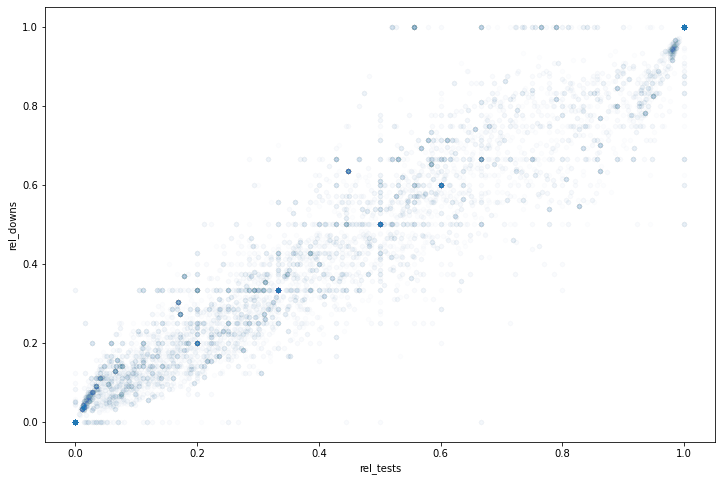

In [17]:
relative_dist4.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.01, figsize=(12, 8))


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

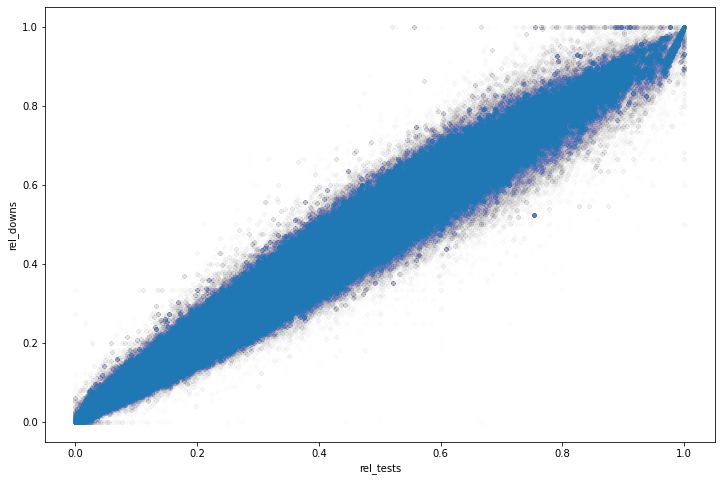

In [18]:
relative_dist.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.005, figsize=(12, 8))


In [19]:
num_points = relative_dist.groupby("spec").aggregate(len).sort_values("rel_tests")

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

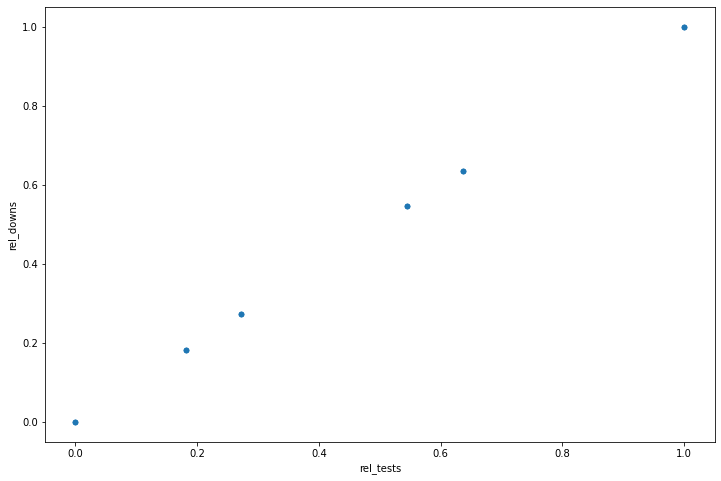

In [20]:
relative_dist.loc[num_points.index[2]].plot.scatter(x="rel_tests", y="rel_downs", figsize=(12, 8))

In [21]:
import os

all_methods_comp = real_statistics
methods = []
for file in os.listdir(dir+"/opti"):
     filename = os.fsdecode(file)
     if filename.endswith(".parquet"):
         table = dd.read_parquet(dir+"opti/"+filename, index=["spec"],columns=["real.tests"])
         table = table.groupby("spec").max()
         method = filename.replace(".parquet", "")
         table = table.rename(columns={"real.tests": method})
         methods.append(method)
         all_methods_comp = all_methods_comp.join(table)
     else:
         continue
all_methods_comp = all_methods_comp.compute()
all_methods_comp

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)",...,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
51892533938074794,56,132,92.750000,26,48,36.250000,4,4,4.0,4,...,88,56,88,56,56,56,56,88,56,56
57036280707606070,168,580,304.250000,85,208,126.383333,6,6,6.0,9,...,202,168,168,168,168,172,168,201,168,196
58056975540577006,38,308,99.733333,14,104,36.166667,6,6,6.0,6,...,60,40,60,46,48,56,48,40,48,60
61760932481443283,51,116,82.166667,21,40,29.083333,4,4,4.0,5,...,88,51,51,88,51,51,51,51,51,88
71494259075619179,34,148,74.166667,16,60,31.833333,4,4,4.0,7,...,44,36,36,34,36,36,34,44,36,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393744352728927060,20,52,32.583333,10,26,15.916667,4,4,4.0,5,...,32,23,23,32,20,23,20,23,23,20
18408939260887928081,146,980,412.285714,68,308,148.038095,7,7,7.0,8,...,324,164,148,148,148,196,146,324,148,172
18414416888391821950,52,82,63.500000,21,33,25.750000,4,4,4.0,4,...,61,52,57,55,52,52,52,61,52,52


In [22]:
def diffs(row):
    new_row = dict()
    mean = row[("real.tests", "mean")]
    for i,c in enumerate(methods, start=1):
        new_row[c] = int(row[c] < mean or row[("real.tests", "min")] == row[("real.tests", "max")])
    return new_row
diffs_comp = all_methods_comp.copy()
diffs_comp = diffs_comp.apply(diffs, axis=1, result_type='expand')
diffs_comp

,sort_min_weights,tricost.dijkstra,init_weights.dijkstra,networkx.min_front,heatmap.min_front,random,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,
51892533938074794,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
57036280707606070,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
58056975540577006,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
61760932481443283,1,1,1,0,1,0,0,1,1,0,1,1,1,1,1,0
71494259075619179,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393744352728927060,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
18408939260887928081,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
18414416888391821950,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Percentage of good optimized specifications by method

In [23]:
diffs_comp.apply(sum, axis=0).sort_values()/len(diffs_comp)

random                    0.580000
sort_min_weights          0.708571
networkx.dijkstra         0.903333
networkx.min_front        0.934286
random.dijkstra           0.948571
heatmap.dijkstra          0.957143
heatmap.min_front         0.966667
random.min_front          0.967143
min_out.tree_width        0.970000
min_out.tree_depth        0.981905
min_out.dijkstra          0.986190
min_out.min_front         0.988095
tricost.dijkstra          0.990476
init_weights.dijkstra     0.992857
tricost.min_front         0.993333
init_weights.min_front    0.994762
dtype: float64

### Visualisation of optimization coverage

<AxesSubplot:xlabel='spec'>

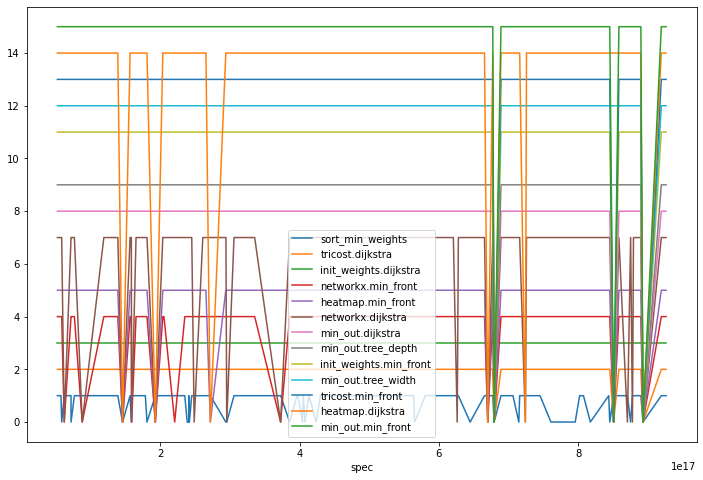

In [24]:
def scale_methods(row):
    new_row = dict()
    for i,c in enumerate(methods, start=1):
        if "random" in c:
            continue
        new_row[c] = i*row[c]
    return new_row
without_rand = diffs_comp.apply(scale_methods, axis=1, result_type='expand')
without_rand.iloc[:100].plot(figsize=(12, 8))

### Cumulative coverage

<AxesSubplot:xlabel='spec'>

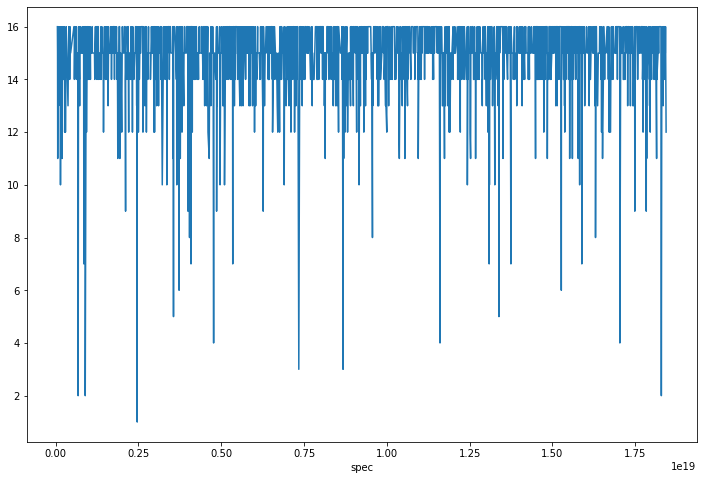

In [25]:
cumulative_comp = diffs_comp.apply(sum, axis=1)
cumulative_comp.plot(figsize=(12, 8))

### Uncovered specifications

In [26]:
cumulative_comp[cumulative_comp == 0]

Series([], dtype: int64)

In [27]:
starting = real_max.compute().reset_index(level="variant")
starting = starting[starting["variant"] == 0]
gain = starting.join(all_methods_comp)
gain = gain[(gain[("real.tests", "max")]/gain[("real.tests", "min")])>1.05]
gain

,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)",...,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,heatmap.dijkstra,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
51892533938074794,0,63,27,4,4,56,132,92.750000,26,48,...,88,56,88,56,56,56,56,88,56,56
57036280707606070,0,232,108,6,9,168,580,304.250000,85,208,...,202,168,168,168,168,172,168,201,168,196
58056975540577006,0,116,44,6,6,38,308,99.733333,14,104,...,60,40,60,46,48,56,48,40,48,60
61760932481443283,0,87,29,4,5,51,116,82.166667,21,40,...,88,51,51,88,51,51,51,51,51,88
71494259075619179,0,44,20,4,7,34,148,74.166667,16,60,...,44,36,36,34,36,36,34,44,36,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393744352728927060,0,51,25,4,5,20,52,32.583333,10,26,...,32,23,23,32,20,23,20,23,23,20
18408939260887928081,0,308,116,7,8,146,980,412.285714,68,308,...,324,164,148,148,148,196,146,324,148,172
18414416888391821950,0,61,26,4,4,52,82,63.500000,21,33,...,61,52,57,55,52,52,52,61,52,52


### Gain in percentage relative to input specification

<AxesSubplot:ylabel='Frequency'>

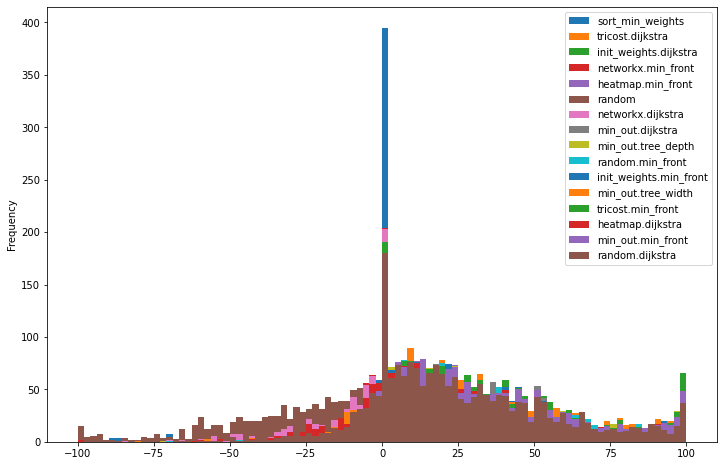

In [28]:
def gains_minus_start(row):
    new_row = dict()
    real = float(row["real.tests"])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (real - float(row[c])) / diff * 100
    return new_row
gain_from_start = gain.apply(gains_minus_start, axis=1, result_type='expand')
gain_from_start.plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain in percentage relative to input specification (specific method)

<AxesSubplot:ylabel='Frequency'>

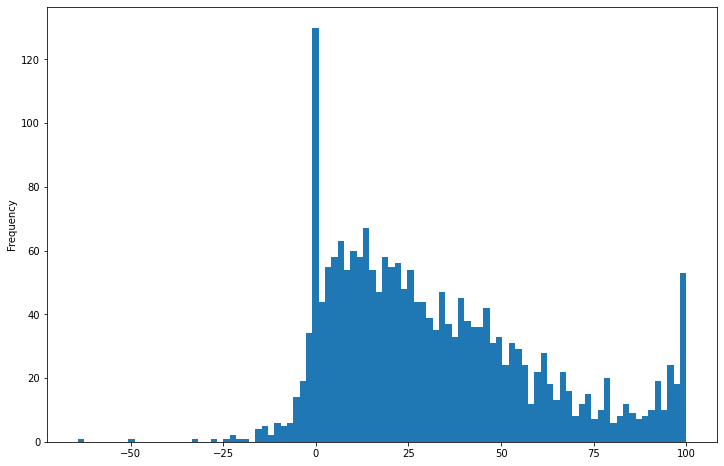

In [29]:
gain_from_start["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### What are the 0 specs?

In [30]:
strange_0_specs = gain_from_start[["init_weights.min_front", ]][gain_from_start["init_weights.min_front"] == 0]
strange_0_specs = strange_0_specs.join(real_statistics.compute()).join(starting)
strange_0_specs

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,init_weights.min_front,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,real.tests,real.downs,size,clocks
spec,,,,,,,,,,,,,,,,,,
240609597492655580,0.0,42,54,45.750000,23,27,24.250000,4,4,4.0,5,5,5.0,0,42,23,4,5
271626161294329481,0.0,68,148,116.000000,32,52,44.000000,4,4,4.0,5,5,5.0,0,68,32,4,5
407659184281095333,0.0,44,116,65.916667,23,56,33.750000,4,4,4.0,6,6,6.0,0,45,24,4,6
423590269474657703,0.0,87,132,100.416667,33,48,38.083333,4,4,4.0,4,4,4.0,0,88,34,4,4
679281214975076496,0.0,84,148,113.333333,36,52,43.333333,4,4,4.0,5,5,5.0,0,116,44,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17403751119763708249,0.0,70,188,111.533333,30,69,44.900000,5,5,5.0,7,7,7.0,0,84,35,5,7
17633427594395212697,0.0,26,66,39.000000,10,24,15.750000,4,4,4.0,4,4,4.0,0,27,11,4,4
17698724222019452952,0.0,38,88,56.916667,16,34,22.250000,4,4,4.0,6,6,6.0,0,40,18,4,6


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

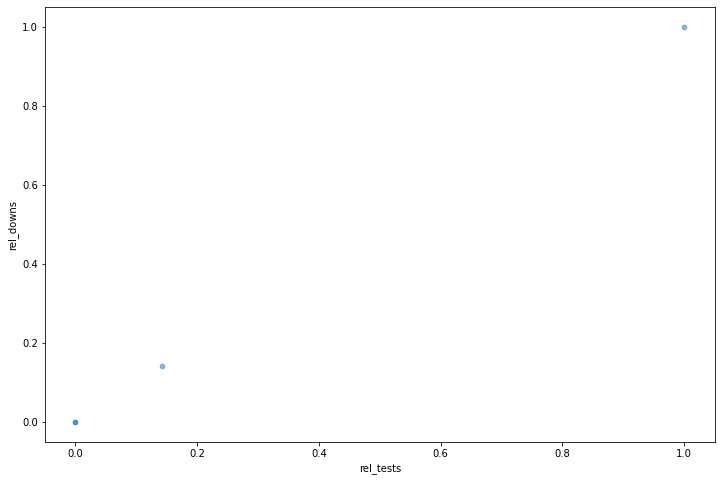

In [31]:
relative_dist.loc[strange_0_specs.index[-1]].plot.scatter(x="rel_tests", y="rel_downs", alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

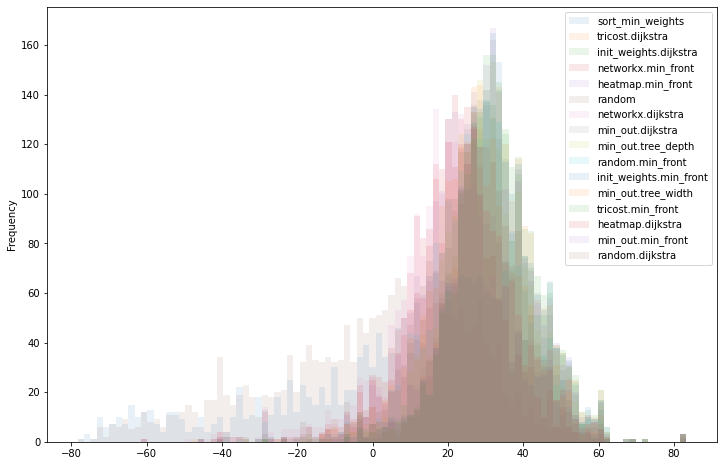

In [32]:
def gains_from_mean(row):
    new_row = dict()
    mean = float(row[("real.tests", "mean")])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (mean - float(row[c])) / diff * 100
    return new_row
gain_from_mean = all_methods_comp.apply(gains_from_mean, axis=1, result_type='expand')
gain_from_mean.plot.hist(bins=96, alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

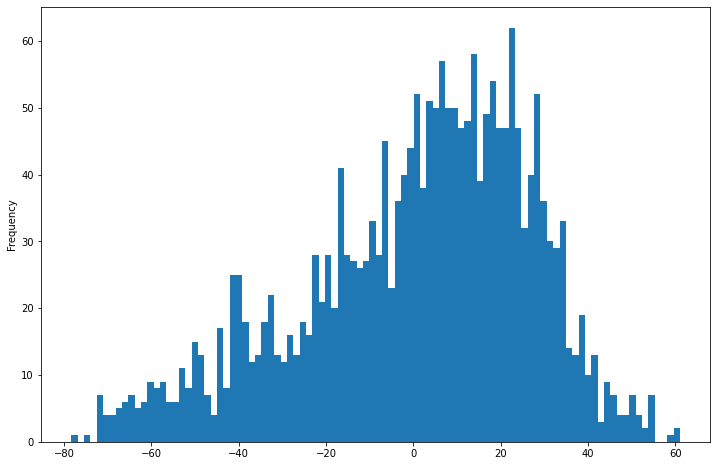

In [47]:
gain_from_mean["random"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

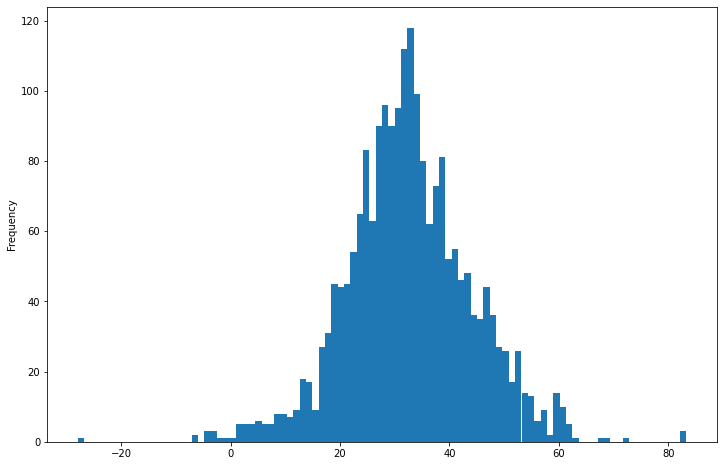

In [49]:
gain_from_mean["init_weights.min_front"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain characteristics per method

In [51]:
gain_from_mean.aggregate(["mean", "std"], axis=0).transpose().sort_values("mean", ascending=False)

,mean,std
tricost.min_front,32.938081,11.371489
init_weights.min_front,32.640788,11.409997
tricost.dijkstra,32.613097,11.524758
init_weights.dijkstra,32.507725,11.493775
min_out.min_front,31.578526,12.016088
min_out.dijkstra,31.175331,11.890395
min_out.tree_depth,29.857040,12.221007
random.min_front,27.317967,13.573338
min_out.tree_width,26.831558,12.998611
random.dijkstra,25.850019,14.508450


### Complexity grow speed (by clocks)

<AxesSubplot:xlabel='clocks'>

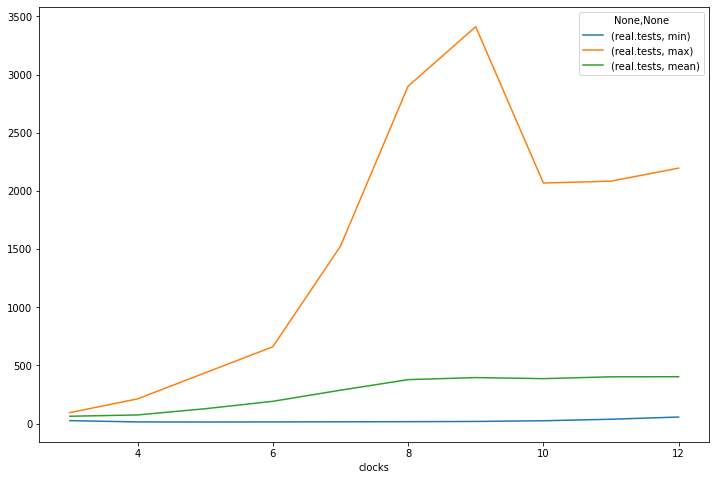

In [35]:
real_max[["clocks", "real.tests"]].groupby("clocks").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

### Complexity grow speed (by size)

<AxesSubplot:xlabel='size'>

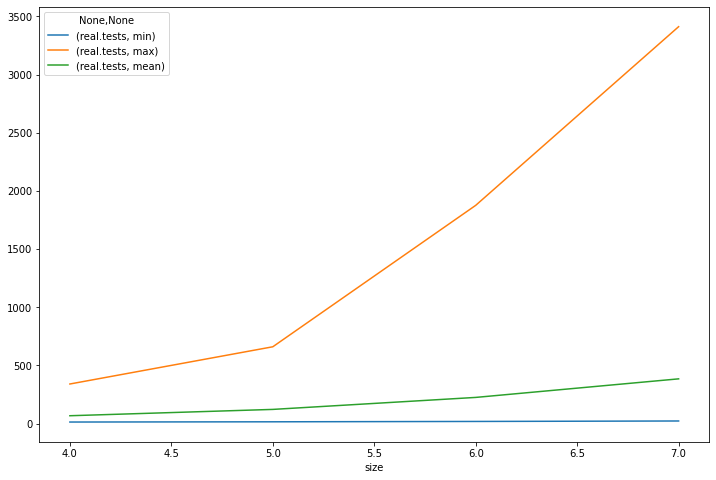

In [36]:
real_max[["size", "real.tests"]].groupby("size").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

In [37]:
comparison_size_clock = comparison_squished.copy()
comparison_size_clock["approx.tests"] = comparison_size_clock["approx.tests"].astype(np.int64)
comparison_size_clock["diff_appr_real"] = ((comparison_size_clock["approx.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock["diff_limit_real"] = ((comparison_size_clock["limit.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock

real.tests  real.downs  size  clocks  \
spec                 variant                                         
51892533938074794    0                63          27     4       4   
                     1                87          33     4       4   
                     2                63          27     4       4   
                     3                87          33     4       4   
                     4                87          33     4       4   
...                                  ...         ...   ...     ...   
18432962492680829874 19               62          28     4       5   
                     20               76          32     4       5   
                     21               54          25     4       5   
                     22               46          23     4       5   
                     23               45          22     4       5   

                              approx.tests  approx.downs  limit.tests  \
spec                 variant                                            
51892533938074794    0                  63            27           63   
                     1                  87            33           87   
                     2                  63            27           63   
                     3                  87            33           87   
                     4                  87            33           87   
...                                    ...           ...          ...   
18432962492680829874 19                 62            27           68   
                     20                 76            31           96   
                     21                 54            25           72   
                     22                 46            22           56   
                     23                 45            22           60   

                              limit.downs  diff_appr_real  diff_limit_real  
spec                 variant                                                
51892533938074794    0                 27             0.0         0.000000  
                     1                 33             0.0         0.000000  
                     2                 27             0.0         0.000000  
                     3                 33             0.0         0.000000  
                     4                 33             0.0         0.000000  
...                                   ...             ...              ...  
18432962492680829874 19                36             0.0         0.096774  
                     20                44             0.0         0.263158  
                     21                36             0.0         0.333333  
                     22                32             0.0         0.217391  
                     23                32             0.0         0.333333  

[2708400 rows x 10 columns]

In [38]:
comparison_size_clock.groupby("size").aggregate("count")
comparison_size_clock.groupby("clocks").aggregate("count")


,real.tests,real.downs,clocks,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
size,,,,,,,,,
4,14400,14400,14400,14400,14400,14400,14400,14400,14400
5,66000,66000,66000,66000,66000,66000,66000,66000,66000
6,360000,360000,360000,360000,360000,360000,360000,360000,360000
7,2268000,2268000,2268000,2268000,2268000,2268000,2268000,2268000,2268000


,real.tests,real.downs,size,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
clocks,,,,,,,,,
3,288,288,288,288,288,288,288,288,288
4,3696,3696,3696,3696,3696,3696,3696,3696,3696
5,41016,41016,41016,41016,41016,41016,41016,41016,41016
6,152736,152736,152736,152736,152736,152736,152736,152736,152736
7,432024,432024,432024,432024,432024,432024,432024,432024,432024
8,905880,905880,905880,905880,905880,905880,905880,905880,905880
9,697200,697200,697200,697200,697200,697200,697200,697200,697200
10,366840,366840,366840,366840,366840,366840,366840,366840,366840
11,78480,78480,78480,78480,78480,78480,78480,78480,78480


### Growth speed of difference of real and approximate complexities (by size)

<AxesSubplot:xlabel='size'>

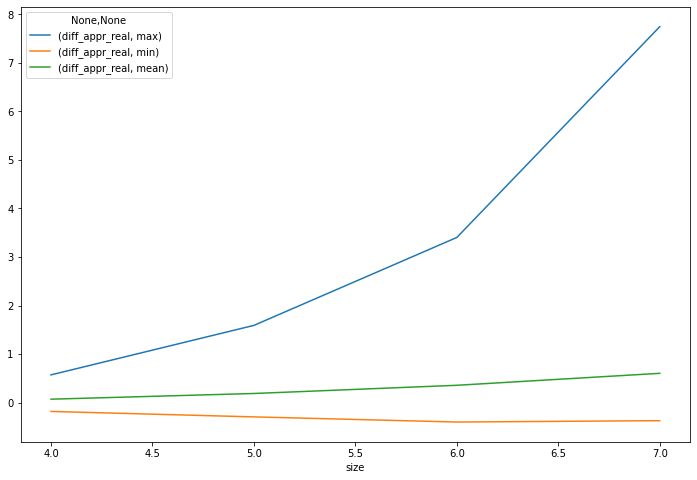

In [43]:
comparison_size_clock[["size", "diff_appr_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='size'>

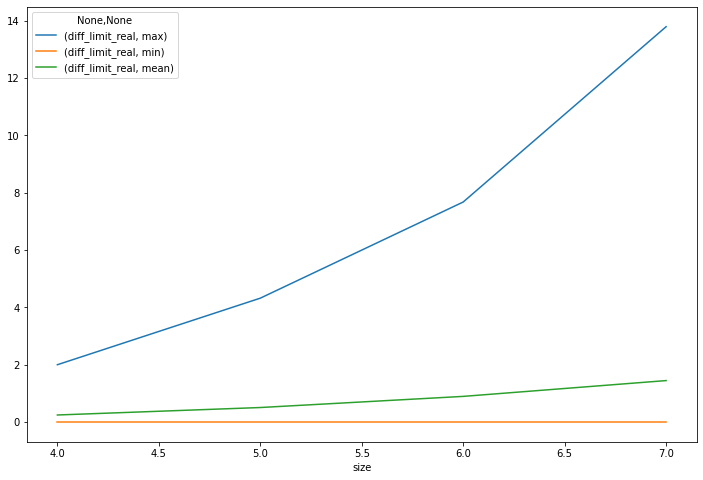

In [44]:
comparison_size_clock[["size", "diff_limit_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))


### Growth speed of difference of real and approximate complexities (by clock)

<AxesSubplot:xlabel='clocks'>

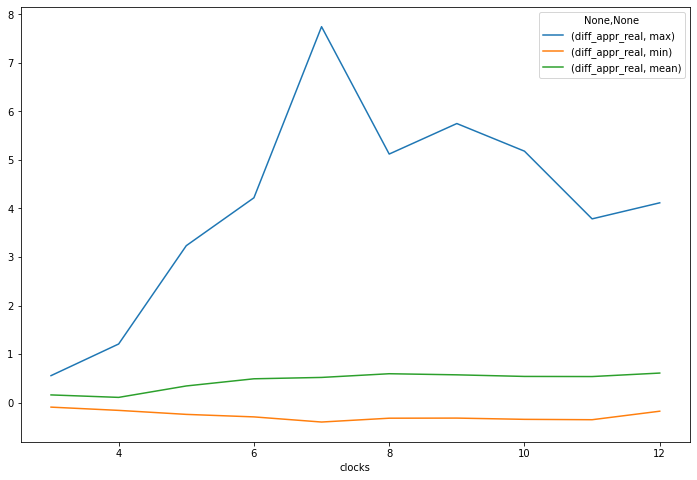

In [45]:
comparison_size_clock[["clocks", "diff_appr_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='clocks'>

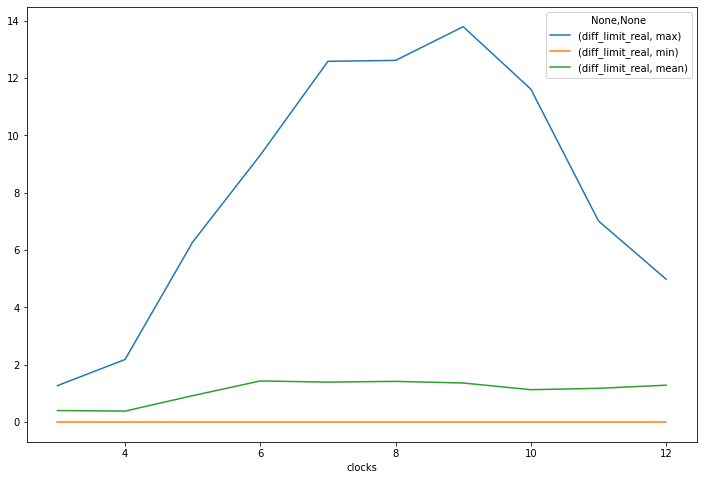

In [46]:
comparison_size_clock[["clocks", "diff_limit_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Check if approximations allow specification comparison

In [41]:
check_order = comparison_squished[["real.tests", "approx.tests"]].reset_index(level="variant").drop("variant", axis=1).groupby("spec").aggregate(list)
check_order

,real.tests,approx.tests
spec,,
51892533938074794,"[63, 87, 63, 87, 87, 87, 64, 88, 56, 84, 116, ...","[63, 87, 63, 87, 87, 87, 64, 88, 56, 84, 164, ..."
57036280707606070,"[232, 292, 324, 432, 436, 532, 196, 256, 204, ...","[382, 517, 414, 432, 612, 712, 320, 430, 341, ..."
58056975540577006,"[116, 84, 116, 84, 76, 76, 148, 116, 212, 196,...","[116, 100, 116, 84, 92, 76, 148, 132, 212, 212..."
61760932481443283,"[87, 87, 87, 55, 87, 55, 88, 88, 92, 82, 116, ...","[87, 87, 87, 71, 87, 71, 88, 88, 92, 82, 164, ..."
71494259075619179,"[44, 60, 68, 148, 84, 148, 42, 58, 34, 34, 58,...","[44, 60, 84, 148, 116, 148, 42, 58, 34, 34, 58..."
...,...,...
18393744352728927060,"[51, 51, 33, 23, 33, 23, 52, 52, 36, 32, 36, 3...","[63, 63, 33, 27, 33, 27, 64, 64, 36, 32, 36, 3..."
18408939260887928081,"[308, 372, 308, 372, 436, 436, 308, 372, 308, ...","[756, 1012, 628, 628, 1012, 756, 756, 1012, 62..."
18414416888391821950,"[61, 64, 61, 58, 82, 76, 60, 63, 75, 67, 62, 5...","[61, 64, 61, 58, 106, 100, 60, 63, 102, 87, 62..."


In [42]:
def order_holds(orig: List[int], aprox: List[int]) -> float:
    candidates = list(zip(orig, aprox))
    hold_times = 0
    count = 0
    for (lorig, laprox), (rorig, raprox) in combinations(candidates, 2):
        ok = (lorig < rorig and laprox < raprox) or \
          (lorig > rorig and laprox > raprox) or \
          (lorig == rorig and laprox == raprox)
        hold_times += int(ok)
        count +=1
    return hold_times/count

check_order["holds"] = check_order.apply(lambda row: order_holds(row["real.tests"], row["approx.tests"]), axis=1)
check_order.holds.mean()

0.8550484649865538